In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


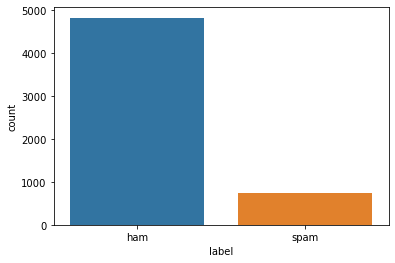

In [4]:
sns.countplot(x=df['label'])
plt.show()

In [5]:
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [6]:
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [7]:
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [8]:
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)
 
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [9]:
nb_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


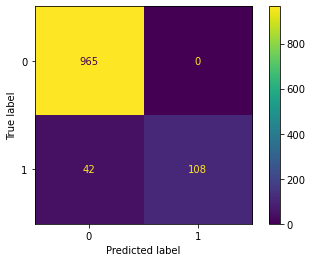

In [10]:
plot_confusion_matrix(baseline_model, X_test_vec, y_test)

In [11]:
MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len
 
text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [12]:
sample_sentence = " This is a message " 
text_vec([ sample_sentence ])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [13]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [14]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
 
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [15]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [16]:
history_1 = model_1.fit(X_test,y_test, epochs = 5, validation_data= (X_test,y_test), validation_steps=int(0.2*len(X_test)))

Epoch 1/5
35/35 [==============================] - 2s 34ms/step - loss: 0.6467 - accuracy: 0.8511 - val_loss: 0.6064 - val_accuracy: 0.8655
Epoch 2/5
35/35 [==============================] - 1s 28ms/step - loss: 0.5995 - accuracy: 0.8789 - val_loss: 0.5907 - val_accuracy: 0.9318
Epoch 3/5
35/35 [==============================] - 1s 35ms/step - loss: 0.5847 - accuracy: 0.9561 - val_loss: 0.5758 - val_accuracy: 0.9776
Epoch 4/5
35/35 [==============================] - 1s 32ms/step - loss: 0.5721 - accuracy: 0.9830 - val_loss: 0.5684 - val_accuracy: 0.9910
Epoch 5/5
35/35 [==============================] - 1s 29ms/step - loss: 0.5681 - accuracy: 0.9910 - val_loss: 0.5664 - val_accuracy: 0.9946


<AxesSubplot:>

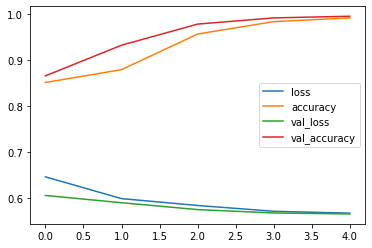

In [17]:
pd.DataFrame(history_1.history).plot()

In [18]:
def compile_model(model):
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
 
def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history
 
def evaluate_model(model, X, y):
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
 
    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}
 
    return model_results_dict

In [19]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)
 
compile_model(model_2)  
history_2 = fit_model(model_2, epochs=5)  

Epoch 1/5
140/140 [==============================] - 11s 40ms/step - loss: 0.1244 - accuracy: 0.9614 - val_loss: 0.0412 - val_accuracy: 0.9910
Epoch 2/5
140/140 [==============================] - 5s 34ms/step - loss: 0.0350 - accuracy: 0.9904 - val_loss: 0.0347 - val_accuracy: 0.9928
Epoch 3/5
140/140 [==============================] - 4s 30ms/step - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.0463 - val_accuracy: 0.9919
Epoch 4/5
140/140 [==============================] - 4s 29ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0616 - val_accuracy: 0.9910
Epoch 5/5
140/140 [==============================] - 4s 30ms/step - loss: 7.2833e-04 - accuracy: 0.9998 - val_loss: 0.0692 - val_accuracy: 0.9919


In [20]:
compile_model(model_2) 
history_2 = fit_model (model_2, epochs=5) 

Epoch 1/5
140/140 [==============================] - 10s 39ms/step - loss: 0.0123 - accuracy: 0.9984 - val_loss: 0.0602 - val_accuracy: 0.9883
Epoch 2/5
140/140 [==============================] - 4s 29ms/step - loss: 0.0019 - accuracy: 0.9991 - val_loss: 0.0640 - val_accuracy: 0.9892
Epoch 3/5
140/140 [==============================] - 4s 30ms/step - loss: 2.3764e-04 - accuracy: 1.0000 - val_loss: 0.0851 - val_accuracy: 0.9883
Epoch 4/5
140/140 [==============================] - 4s 30ms/step - loss: 1.7500e-05 - accuracy: 1.0000 - val_loss: 0.0891 - val_accuracy: 0.9883
Epoch 5/5
140/140 [==============================] - 4s 29ms/step - loss: 1.2495e-05 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9883


In [21]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
 
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results}).transpose()
 

35/35 [==============================] - 1s 4ms/step


In [22]:
total_results

,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.984753,1.000000,0.886667,0.939929
Bidirectional-LSTM Model,0.988341,0.985816,0.926667,0.955326
